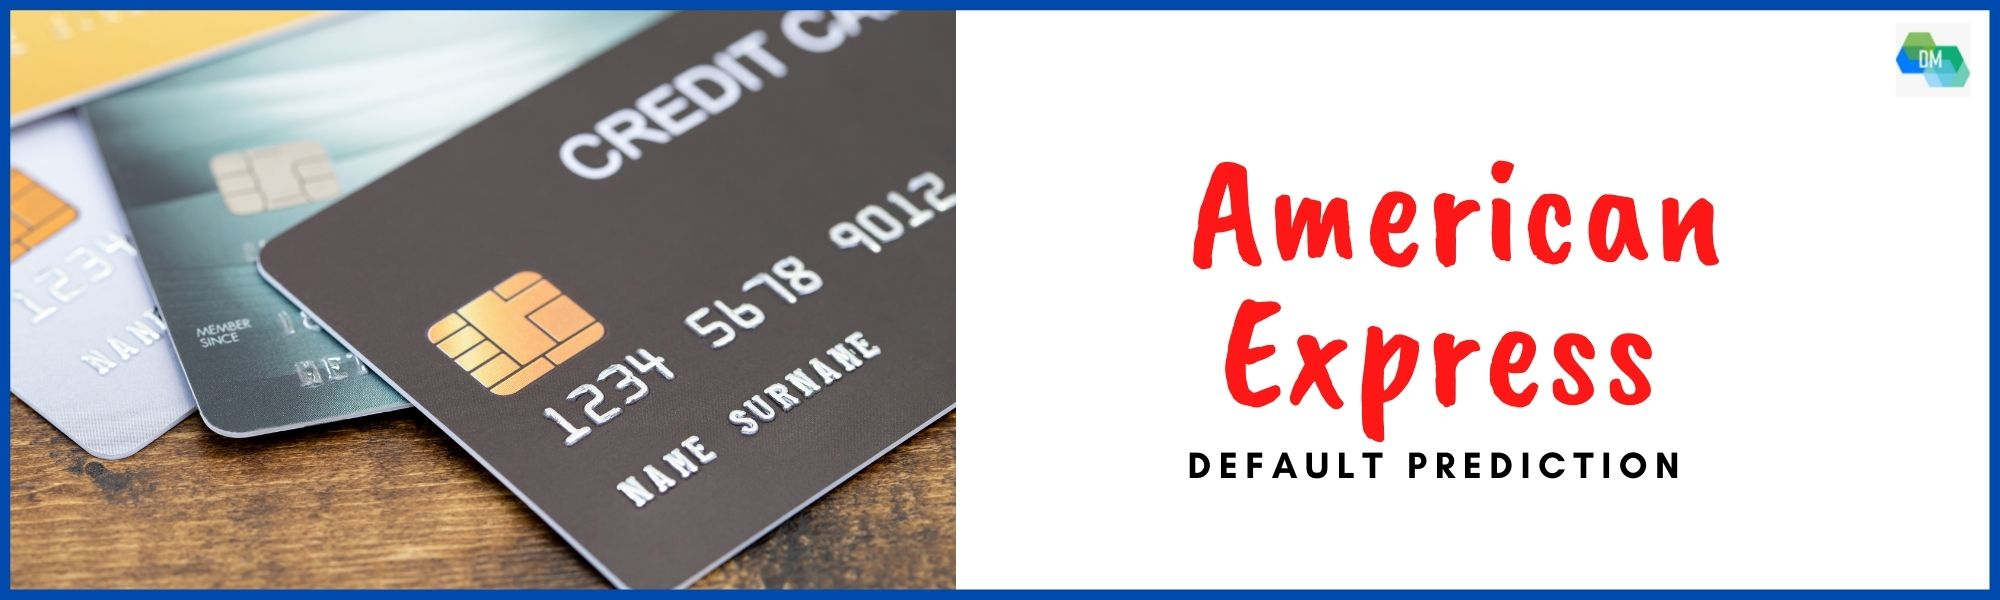

<p style="font-family: Arials; font-size: 20px;text-align: center;; font-style: normal;line-height:1.3">The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. </p>

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- `D_*` = Delinquency variables
- `S_*` = Spend variables
- `P_*` = Payment variables
- `B_*` = Balance variables
- `R_*` = Risk variables

With the following features being categorical:`B_30`,`B_38`,`D_114`,`D_116`,`D_117`,`D_120`,`D_126`,`D_63`,`D_64`, `D_66`,`D_68`

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

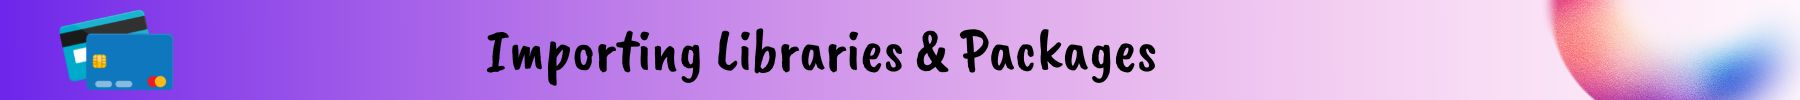

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

import warnings, gc
warnings.filterwarnings('ignore')

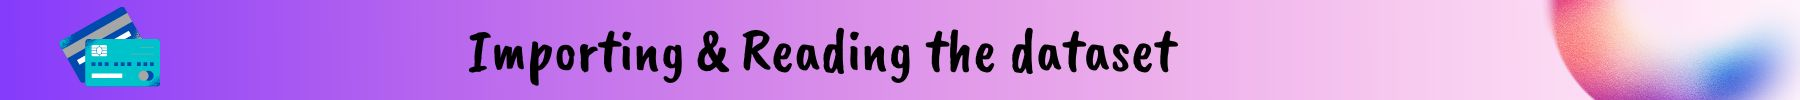

In [ ]:
df_train = pd.read_feather('../input/amexfeather/train_data.ftr')
df_train = df_train.groupby('customer_ID').tail(1).set_index('customer_ID')

df_test = pd.read_feather('../input/amexfeather/test_data.ftr')
df_test = df_test.groupby('customer_ID').tail(1).set_index('customer_ID')

df_subm = pd.read_csv("../input/amex-default-prediction/sample_submission.csv")

In [ ]:
#Custom Color Palette 🎨
custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

In [ ]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows (Train):', df_train_row_count)
print('Total number of columns (Train):', df_train_column_count)

In [ ]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total number of rows (Test):', df_test_row_count)
print('Total number of columns (Test):', df_test_column_count)

In [ ]:
df_train['S_2'] = pd.to_datetime(df_train['S_2'])
df_test['S_2'] = pd.to_datetime(df_test['S_2'])

In [ ]:
print('Duration (Train Date): ', df_train['S_2'].min(), df_train['S_2'].max())
print('Duration (Test Date): ', df_test['S_2'].min(), df_test['S_2'].max())

In [ ]:
df_train.head()

In [ ]:
df_train.info()

In [ ]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [ ]:
feat_Delinquency = [c for c in df_train.columns if c.startswith('D_')]
feat_Spend = [c for c in df_train.columns if c.startswith('S_')]
feat_Payment = [c for c in df_train.columns if c.startswith('P_')]
feat_Balance = [c for c in df_train.columns if c.startswith('B_')]
feat_Risk = [c for c in df_train.columns if c.startswith('R_')]
print(f'Total number of Delinquency variables: {len(feat_Delinquency)}')
print(f'Total number of Spend variables: {len(feat_Spend)}')
print(f'Total number of Payment variables: {len(feat_Payment)}')
print(f'Total number of Balance variables: {len(feat_Balance)}')
print(f'Total number of Risk variables: {len(feat_Risk)}')

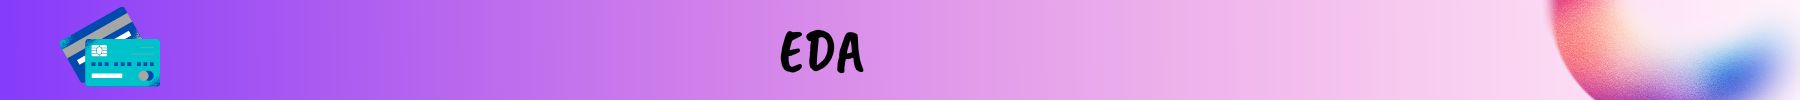

In [ ]:
labels=['Delinquency', 'Spend','Payment','Balance','Risk']
values= [len(feat_Delinquency), len(feat_Spend),len(feat_Payment), len(feat_Balance),len(feat_Risk)]

In [ ]:
fig_1 = go.Figure()
fig_1.add_trace(go.Pie(values = values,labels = labels,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig_1.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,marker = dict(colors =["#70d6ff","#ff9770"]),
                  title = dict(text = 'Feature Distribution'))  
fig_1.show()

In [ ]:
df_train.isna().sum()

In [ ]:
sum(df_train.isna().sum())

In [ ]:
background_color = 'white'
missing = pd.DataFrame(columns = ['% Missing values'],data = df_train.isnull().sum()/len(df_train))
fig = plt.figure(figsize = (20, 60),facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.5, hspace = 0.5)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top","bottom","left"]:
    ax0.spines[s].set_visible(False)
sns.heatmap(missing,cbar = False,annot = True,fmt =".2%", linewidths = 2,cmap = custom_colors,vmax = 1, ax = ax0)
plt.show()

In [ ]:
target_class = pd.DataFrame({'count': df_train.target.value_counts(),
                             'percentage': df_train['target'].value_counts() / df_train.shape[0] * 100
})

In [ ]:
target_class 

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Pie(values = target_class['count'],labels = target_class.index,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,marker = dict(colors =["#90cf8e","#ff70a6"]),
                  title = dict(text = 'Target Distribution'))  
fig.show()

In [ ]:
stat_plot = df_train.reset_index().groupby('S_2')['customer_ID'].nunique().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x = stat_plot['S_2'], y = stat_plot['customer_ID']))
fig.update_layout(title="Customer Statements", width = 800, height = 600,xaxis_title ='Statement Date',
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)') 
fig['data'][0]['line']['color']="#ff9770"
fig.show()

In [ ]:
gc.collect()

In [ ]:
del_cols = [c for c in df_train.columns if (c.startswith(('D','t'))) & (c not in cat_cols)]
df_del = df_train[del_cols]
spd_cols = [c for c in df_train.columns if (c.startswith(('S','t'))) & (c not in cat_cols)]
df_spd = df_train[spd_cols]
pay_cols = [c for c in df_train.columns if (c.startswith(('P','t'))) & (c not in cat_cols)]
df_pay = df_train[pay_cols]
bal_cols = [c for c in df_train.columns if (c.startswith(('B','t'))) & (c not in cat_cols)]
df_bal = df_train[bal_cols]
ris_cols = [c for c in df_train.columns if (c.startswith(('R','t'))) & (c not in cat_cols)]
df_ris = df_train[ris_cols]

In [ ]:
fig, axes = plt.subplots(29, 3, figsize = (40,150))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(del_cols) - 1:
        sns.kdeplot(x = del_cols[i], hue='target', data = df_del, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
fig.suptitle('Distribution of Delinquency Variables', fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize =(11,11))
corr = df_del.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation of Delinquency Variables')
plt.show()

In [ ]:
fig, axes = plt.subplots(8, 3, figsize = (16,18))
fig.suptitle('Distribution of Spend Variables', fontsize = 15, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(spd_cols) - 1:
        sns.kdeplot(x = spd_cols[i], hue ='target', data = df_spd, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
S_cols = [c for c in df_train.columns if (c.startswith(('S')))]
df_S = df_train[S_cols]

In [ ]:
plt.figure(figsize = (11,11))
corr = df_S.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths = .6, cmap = custom_colors)
plt.title('Correlation of Spend Variables')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (12,4))
fig.suptitle('Distribution of Payment Variables',fontsize = 15)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(pay_cols) - 1:
        sns.kdeplot(x = pay_cols[i], hue ='target', data = df_pay, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
P_cols = [c for c in df_train.columns if (c.startswith(('P')))]
df_P = df_train[P_cols]

In [ ]:
plt.figure(figsize = (6,6))
corr = df_P.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths = .6, cmap = custom_colors)
plt.title('Correlation of Payment Variables')
plt.show()

In [ ]:
fig, axes = plt.subplots(10, 4, figsize = (15,24))
fig.suptitle('Distribution of Balance Variables',fontsize = 15, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(bal_cols) - 1:
        sns.kdeplot(x = bal_cols[i], hue ='target', data = df_bal, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
B_cols = [c for c in df_train.columns if (c.startswith(('B')))]
df_B = df_train[B_cols]

In [ ]:
plt.figure(figsize = (11,11))
corr = df_B.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust=True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation of Balance Variables')
plt.show()

In [ ]:
fig, axes = plt.subplots(10, 3, figsize = (18,23))
fig.suptitle('Distribution of Risk Variables',fontsize=15, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(ris_cols) - 1:
        sns.kdeplot(x = ris_cols[i], hue ='target', data = df_ris, fill = True, ax = ax, palette =["#e63946","#8338ec"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
R_cols = [c for c in df_train.columns if (c.startswith(('R')))]
df_R = df_train[R_cols]

In [ ]:
plt.figure(figsize=(11,11))
corr = df_R.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0, square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation of Risk Variables')
plt.show()

In [ ]:
palette = cycle(["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"])
targ = df_train.corrwith(df_train['target'], axis=0)
val = [str(round(v ,1) *100) + '%' for v in targ.values]
fig = go.Figure()
fig.add_trace(go.Bar(y=targ.index, x= targ.values, orientation='h',text = val, marker_color = next(palette)))
fig.update_layout(title = "Correlation of variables with Target",width = 750, height = 3500,
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)')

In [ ]:
gc.collect()

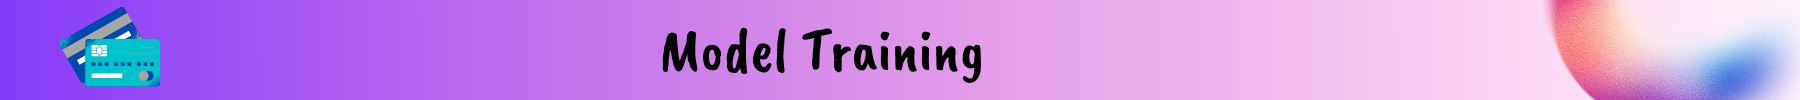

In [ ]:
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
for cat_feat in cat_cols:
    df_train[cat_feat] = lab_enc.fit_transform(df_train[cat_feat])
    df_test[cat_feat] = lab_enc.transform(df_test[cat_feat])

In [ ]:
#Reference: https://www.kaggle.com/code/inversion/amex-competition-metric-python/notebook
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [ ]:
# define dataset
X = df_train.drop('target', axis=1)
y = df_train['target']

In [ ]:
from sklearn.model_selection import train_test_split

# creating dataset split for prediction
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations = 3000, random_state = 42, nan_mode ='Min',task_type ="GPU")
clf.fit(X_train, y_train, eval_set = [(X_test, y_test)], cat_features=cat_cols,  verbose = 100)
preds = clf.predict_proba(X_test)[:, 1]

In [ ]:
y_preds = clf.predict_proba(df_test)[:, 1]
y_preds

In [ ]:
df_subm["prediction"] = y_preds
df_subm.to_csv('submission_catb.csv', index=False)
df_subm

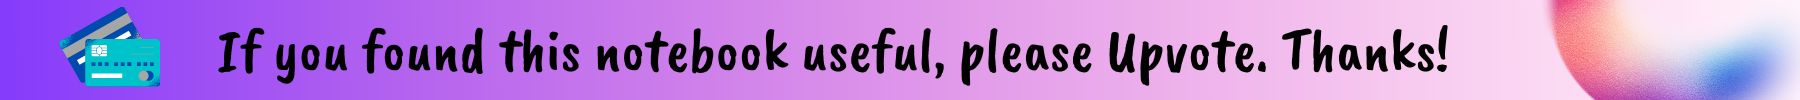